# 230968364 Manish R
## Week 7 Q1

In [2]:
import pandas as pd
import numpy as np
import graphviz
import os
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
# Load dataset
df = pd.read_csv("D:\\230968364\\week7\\German Credit Data.csv")
df

,checkin_acc,duration,credit_history,amount,savings_acc,present_emp_since,inst_rate,personal_status,residing_since,age,inst_plans,num_credits,job,status
0,A11,6,A34,1169,A65,A75,4,A93,4,67,A143,2,A173,0
1,A12,48,A32,5951,A61,A73,2,A92,2,22,A143,1,A173,1
2,A14,12,A34,2096,A61,A74,2,A93,3,49,A143,1,A172,0
3,A11,42,A32,7882,A61,A74,2,A93,4,45,A143,1,A173,0
4,A11,24,A33,4870,A61,A73,3,A93,4,53,A143,2,A173,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,1736,A61,A74,3,A92,4,31,A143,1,A172,0
996,A11,30,A32,3857,A61,A73,4,A91,4,40,A143,1,A174,0
997,A14,12,A32,804,A61,A75,4,A93,4,38,A143,1,A173,0
998,A11,45,A32,1845,A61,A73,4,A93,4,23,A143,1,A173,1


### 1. Decision tree classifier to predict good or bad credit. Use “sklearn.model_selection” and GridSearchCV to search the hyperparameter values and report the most optimal one. Configure the grid search to search for optimal parameters: • Splitting criteria: gini or entropy. • Maximum depth of decision tree ranging from 2 to 10. • The searching of optimal parameter will be validated using 10-fold cross validation and the most optimal parameter will be chosen based on ROC AUC score.

In [3]:
# Define categorical and numerical features
categorical_features = ['checkin_acc', 'credit_history', 'savings_acc', 'present_emp_since', 
                         'personal_status', 'inst_plans', 'job']
numerical_features = ['duration', 'amount', 'inst_rate', 'residing_since', 'age', 'num_credits']

# Define preprocessor for encoding categorical variables
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# Split data into features and target variable
X = df.drop(columns=['status'])  # Features
y = df['status']  # Target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor
preprocessor.fit(X_train)

# Create a pipeline with preprocessing and decision tree classifier
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': range(2, 11)
}

# Define GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(
    estimator=clf_pipeline,
    param_grid=param_grid,
    scoring=make_scorer(roc_auc_score),
    cv=10,
    n_jobs=-1
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Best Parameters:", best_params)
print("Best ROC AUC Score (Validation):", best_score)
print("ROC AUC Score (Test Set):", roc_auc)

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 4}
Best ROC AUC Score (Validation): 0.620780303030303
ROC AUC Score (Test Set): 0.7588652482269505


### 2. Visualize the tree using graphviz toolkit.

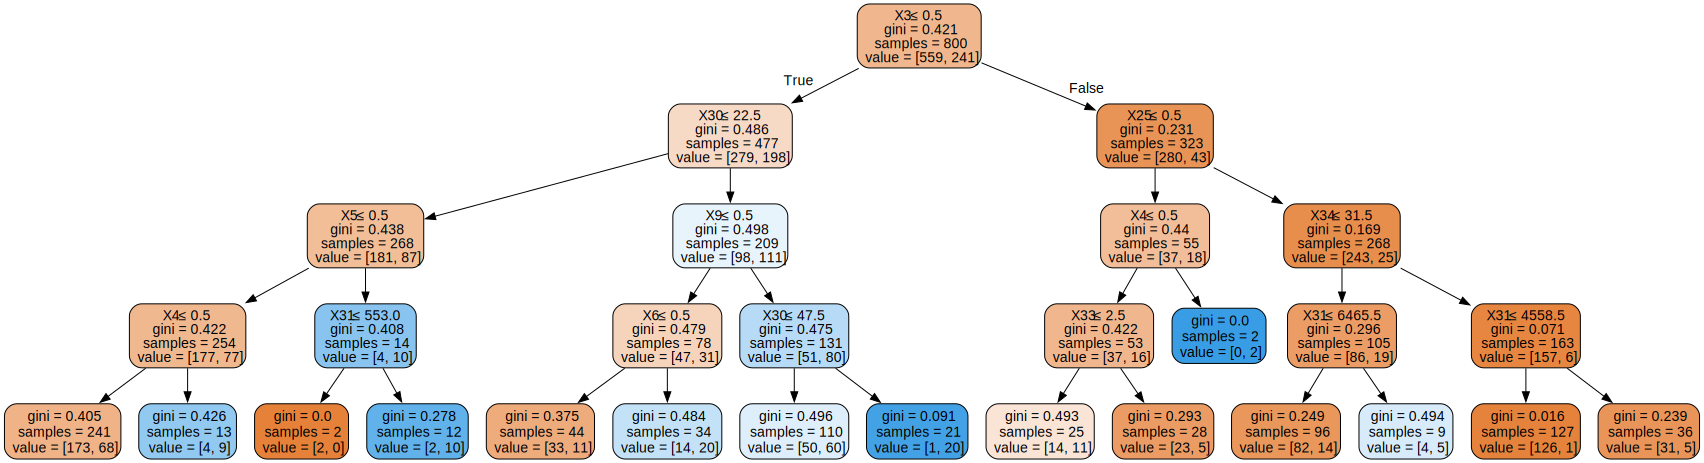

In [4]:
# Visualize the tree using Graphviz
dot_data = export_graphviz(best_model.named_steps['classifier'], out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")
display(graph)

### 3. Display the text representation of the rules learnt.

In [5]:
# Display text representation of the tree
feature_names = preprocessor.get_feature_names_out()
tree_rules = export_text(best_model.named_steps['classifier'], feature_names=list(feature_names))
print(tree_rules)

|--- cat__checkin_acc_A14 <= 0.50
|   |--- remainder__duration <= 22.50
|   |   |--- cat__credit_history_A31 <= 0.50
|   |   |   |--- cat__credit_history_A30 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- cat__credit_history_A30 >  0.50
|   |   |   |   |--- class: 1
|   |   |--- cat__credit_history_A31 >  0.50
|   |   |   |--- remainder__amount <= 553.00
|   |   |   |   |--- class: 0
|   |   |   |--- remainder__amount >  553.00
|   |   |   |   |--- class: 1
|   |--- remainder__duration >  22.50
|   |   |--- cat__savings_acc_A61 <= 0.50
|   |   |   |--- cat__credit_history_A32 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- cat__credit_history_A32 >  0.50
|   |   |   |   |--- class: 1
|   |   |--- cat__savings_acc_A61 >  0.50
|   |   |   |--- remainder__duration <= 47.50
|   |   |   |   |--- class: 1
|   |   |   |--- remainder__duration >  47.50
|   |   |   |   |--- class: 1
|--- cat__checkin_acc_A14 >  0.50
|   |--- cat__inst_plans_A143 <= 0.50
|   |   |--- cat__credit_h